In [5]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
#import del file, questo blocco è troppo rigido, va automatizzato nella class in modo da utilizzare tutta la serie storica disponibile degli strumenti che si vogliono in portafoglio (cioè con peso maggiore di 0)
imported_dataframe= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TBTFolio - testing/Timeseries.csv", sep = ";")

# Converte la colonna Date in datetime
imported_dataframe["Date"] = pd.to_datetime(imported_dataframe["Date"], dayfirst=True, errors="coerce")
# Tieni solo le righe con Date >= cutoff
imported_dataframe = imported_dataframe[(imported_dataframe["Date"]>=pd.to_datetime("2000-01-03"))].copy()
imported_dataframe = imported_dataframe[(imported_dataframe["Date"]<=pd.to_datetime("2025-09-04"))].copy().reset_index(drop=True)
print(imported_dataframe)

           Date       VTSIM      SPYSIM     VXUSSIM     GLDSIM      CASHX  \
0    2000-01-03   363024.65   456485.64   312227.52   22917.49  500897.68   
1    2000-01-04   352086.78   438635.96   305738.53   22226.61  501002.43   
2    2000-01-05   347231.97   439422.28   297085.70   22143.70  501107.41   
3    2000-01-06   344163.69   432361.79   292760.28   22060.80  501211.80   
4    2000-01-07   351764.33   457473.35   297522.70   22273.98  501315.63   
...         ...         ...         ...         ...        ...        ...   
6452 2025-08-28  1889394.90  3296256.53  1003068.28  269150.92  806813.61   
6453 2025-08-29  1879006.49  3276610.82   997844.32  271752.46  806943.27   
6454 2025-09-02  1865527.77  3252342.51   991312.49  278181.71  807072.96   
6455 2025-09-03  1872416.52  3269981.07   993499.24  280364.83  807202.03   
6456 2025-09-04  1885766.77  3297321.91   997429.77  279130.39  807330.47   

         SHYSIM     IEFSIM     TLTSIM    ZROZSIM   KMLMSIM   DBMFSIM  
0   

In [ ]:
#in caso di problemi con l'import del csv lanciare il blocco
#!ls "/content/drive/MyDrive"
#!ls "/content/drive/MyDrive/Colab Notebooks"
#!ls "/content/drive/MyDrive/Colab Notebooks/TBTFolio - testing"

In [13]:
class portfolio:

    colonne_escluse = ["Date"]  # colonne da escludere nell'import del DF nell'oggetto

    def __init__(self, initial_balance, transac_cost_rate, tax_rate, exp_rate, rebalance_threshold,
                 initial_w, imported_dataframe, stock_price_normalization = True):
        self.TotValue                 = initial_balance         # Valore totale del PTF
        self.NetTotValue              = self.TotValue           # Valore totale del PTF sottraendo  tasse e costi di transazione
        self.transactional_cost_rate  = transac_cost_rate       # Percentuale costi di transazione come somma %commissioni e %spread
        self.TransactionalCost        = 0                       # Inizializzazione costo di transazione progressivo
        self.tax_rate                 = tax_rate                # Percentuale tassazione plusvalenza
        self.exp_rate                 = exp_rate                # Tasso spesa annuo in cui inserire la somma di tracking error + 0.2% di imposta di bollo sul dossier titoli
        self.tax                      = 0                       # Inizializzazione tassazione progressiva
        self.rebalance_threshold      = rebalance_threshold     # Soglia per effettuare il ribilanciamento dei pesi

        self.df                       = imported_dataframe      # DataFrame di input

        self.IndexName         = [                              # Set dei nomi degli asset in PTF
            col for col in self.df.columns
            if col not in self.colonne_escluse
        ]

        if stock_price_normalization:                                                       # Inizializzazione prezzi degli asset (via normalizzazione o non)
            self.StockPrice = self.df.loc[:,self.IndexName]/self.df.loc[0,self.IndexName]
        else:
            self.StockPrice = self.df.loc[:,self.IndexName]

        self.date                = pd.to_datetime(self.df['Date'], format = '%d/%m/%Y')     # Date della serie storica
        self.initial_w           = pd.Series(data = initial_w, index = self.IndexName)      # Setting pesi teorici (valori da mantenere in PTF)
        self.w                   = self.initial_w                                           # Inizializzazione dei pesi effettivi
        self.delta_notional      = 0
        self.AssetValue          = self.TotValue*self.w                                     # Inizializzazione valore degli asset in PTF
        self.PMC                 = self.StockPrice.loc[0,:]                                 # Inizializzazione Prezzo Medio di Carico
        self.PMC_weight          = pd.Series(data = 1, index = self.IndexName)              # Inizializzazione denomionatore media pesata per calcolo PMC
        self.notional            = self.AssetValue/self.StockPrice.loc[0,:]                 # Inizializzazione notional degli asset
        self.PercReturn          = 0                                                        # Inizializzazione rendimenti percentuali
        self.CompoundReturn      = 1                                                        # Inizializzazione rendimenti composti

    def update_TotValue(self, StockPrice):
        #StockPrice deve essere una Series col nome degli Stock come indici
        self.TotValue = self.calculate_TotValue(StockPrice)

    # def update_AssetValue(self, StockPrice):
    #     #StockPrice deve essere una Series col nome degli Stock come indici
    #     self.AssetValue = self.calculate_AssetValue(StockPrice)

    def update_NetTotValue(self, StockPrice):
        #StockPrice deve essere una Series col nome degli Stock come indici
        self.NetTotValue = self.calculate_NetTotValue(StockPrice)

    def update_AssetValue_weight(self,StockPrice):
        self.AssetValue = self.notional * StockPrice
        self.w = self.AssetValue/self.calculate_TotValue(StockPrice)

    def calculate_TotValue(self,StockPrice):
        #StockPrice deve essere una Series col nome degli Stock come indici
        return self.notional.dot(StockPrice)

    def calculate_NetTotValue(self, StockPrice):
        #StockPrice deve essere una Series col nome degli Stock come indici
        return self.calculate_TotValue(StockPrice) + self.TransactionalCost + self.tax

    # def calculate_AssetValue(self, StockPrice):
    #     return self.notional * StockPrice

    def update_Return(self, StockPrice):
        old_NetTotValue = self.NetTotValue
        current_NetTotValue = self.calculate_NetTotValue(StockPrice)
        self.PercReturn = current_NetTotValue/old_NetTotValue - 1
        self.CompoundReturn *= 1 + self.PercReturn

    def update_PMC(self,StockPrice):
        mask_buy = self.delta_notional > 0
        self.PMC = self.PMC.copy() #?
        self.PMC[mask_buy] = (self.PMC[mask_buy]*self.PMC_weight[mask_buy]
                              + (self.delta_notional*StockPrice)[mask_buy] )
        self.PMC_weight[mask_buy] += self.delta_notional[mask_buy]
        self.PMC[mask_buy] /= self.PMC_weight[mask_buy]

    def update_tax(self,StockPrice):
        mask_tax = (self.delta_notional < 0) & (StockPrice > self.PMC)
        if np.sum(mask_tax) >0:
            self.tax = (self.delta_notional*StockPrice)[mask_tax].sum()*self.tax_rate
        else:
            self.tax = 0

    def update_transactional_cost(self, StockPrice):
        self.TransactionalCost = -(abs(self.delta_notional)*StockPrice).sum()*self.transactional_cost_rate

    def update_notional_tax_transaccost(self, StockPrice):
        self.delta_notional = (self.initial_w - self.w)*self.calculate_TotValue(StockPrice)/StockPrice
        self.update_PMC(StockPrice)
        self.update_tax(StockPrice)
        self.update_transactional_cost(StockPrice)
        self.notional += self.delta_notional

    def reset_tax_transaccost(self):
        self.tax = 0
        self.TransactionalCost = 0

    def reset_delta_notional(self):
        self.delta_notional = 0

    def check_rebalance(self):
        if sum( np.abs(self.w - self.initial_w) > self.rebalance_threshold) > 0:
            return True
        else:
            return False

/tmp/ipython-input-1932929713.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[np.float64(125.75168277597467) np.float64(7.054351070443468)]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.PMC_weight[mask_buy] += self.delta_notional[mask_buy]


Orizzonte temporale   2000-01-03 / 2025-09-04
Anni in simulazione   25.67
CAGR                  8.07%
Total compound return 733.44%


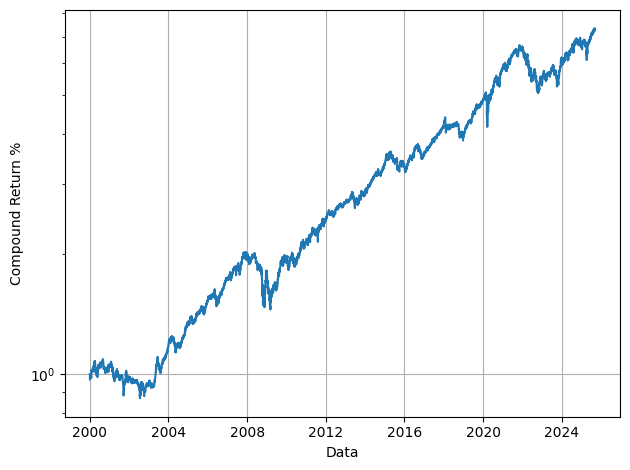

In [17]:
## RUN PRINCIPALE ##
# Allocazione su indici di portafoglio:
# Index 1  # Index 2 # Index 3 # Index 4 ...
#             VTSIM SPYSIM  VXUSSIM GLDSIM  CASHX SHYSIM  IEFSIM  TLTSIM  ZROZSIM KMLMSIM DBMFSIM
initial_w = [ 0.6,  0,      0,      0.05,   0,    0,      0,      0,      0.25,   0.05,   0.05]

if np.sum(initial_w) != 1:
    print("L'allocazione non somma a 1")
    sys.exit()

ptf = portfolio(initial_balance = 1000,
                transac_cost_rate= 0.0029, #0.19% commissioni + 0.1% spread
                exp_rate=0.002,            #0.2% imposta di bollo + 0% tracking error
                tax_rate = 0.26,           #26% conservativo
                rebalance_threshold = 0.1,
                initial_w = initial_w,
                imported_dataframe= imported_dataframe,
                stock_price_normalization= True)

df_log       = pd.DataFrame(index = ptf.date)
df_log_delta = pd.DataFrame(index = ptf.date)


for i in ptf.StockPrice.index:
    ptf.reset_tax_transaccost()
    ptf.reset_delta_notional()

    StockPrice = ptf.StockPrice.loc[i,:]
    ptf.update_AssetValue_weight(StockPrice)

    if ptf.check_rebalance():
        ptf.update_notional_tax_transaccost(StockPrice)
    ptf.update_Return(StockPrice)
    ptf.update_TotValue(StockPrice)
    ptf.update_NetTotValue(StockPrice)

    df_log.loc[ptf.date[i], "Return"]                = ptf.PercReturn
    df_log.loc[ptf.date[i], "Compound Return"]       = ptf.CompoundReturn
    df_log.loc[ptf.date[i], "TotValue"]              = ptf.TotValue
    df_log.loc[ptf.date[i], "Taxes"]                 = ptf.tax
    df_log.loc[ptf.date[i], "TransacCost"]           = ptf.TransactionalCost
    df_log.loc[ptf.date[i], ptf.IndexName]           = ptf.AssetValue
    df_log_delta.loc[ptf.date[i], ptf.IndexName]     = ptf.delta_notional*StockPrice

df_log.to_excel("output_ptf.xlsx")
df_log_delta.to_excel("output_ptf_delta.xlsx")

print(f"Orizzonte temporale   {min(ptf.date).date()} / {max(ptf.date).date()}")
print(f"Anni in simulazione   {round(((max(ptf.date) - min(ptf.date)).days / 365.25), 2)}")
print(f"CAGR                  {(ptf.CompoundReturn**(1/(round(((max(ptf.date) - min(ptf.date)).days / 365.25), 2))) -1) * 100:.2f}%")
print(f"Total compound return {ptf.CompoundReturn * 100:.2f}%")
plt.semilogy(df_log.index,df_log['Compound Return'])
plt.xlabel('Data')
plt.ylabel('Compound Return %')
#plt.title('Grafico')
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()